In [8]:
import timeit
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
from cmcrameri import cm 

In [ ]:
"""
I changed the code so that for each domain size it gives a dims_nxlen_nylen and an out_nxlen_ny_len file, with nxlen and nylen the size of the domain. The dims file give
the dimensions of nx and ny on rank number 0, to see how the domain is split up. Everything you run the code the thread and core number and runtime or dimensions will be
appended to those files and it will not get overwritten anymore. 
The speedup give the speedup compared to the base configuration of 1 core and 1 thread. 
"""

In [ ]:
os.environ["OMP_NUM_THREADS"] = "72"
os.environ["OMP_PROC_BIND"] = "close"
os.environ["OMP_PLACES"] = "cores"
os.environ["OMP_STACKSIZE"] = "1G"

In [13]:
%%bash
make clean

rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report result_*.py report*.txt perf/*


In [14]:
%%bash
make clean
make VERSION=kparallel_mpi

rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report result_*.py report*.txt perf/*
mpif90 -ffree-line-length-none  -g1 -O3 -fno-inline -fno-optimize-sibling-calls -fno-omit-frame-pointer -march=native -funroll-loops -fopenmp -flto -fno-math-errno -c m_utils.F90
mpif90 -ffree-line-length-none  -g1 -O3 -fno-inline -fno-optimize-sibling-calls -fno-omit-frame-pointer -march=native -funroll-loops -fopenmp -flto -fno-math-errno -c m_partitioner.F90
mpif90 -ffree-line-length-none  -g1 -O3 -fno-inline -fno-optimize-sibling-calls -fno-omit-frame-pointer -march=native -funroll-loops -fopenmp -flto -fno-math-errno -c stencil2d-kparallel_mpi.F90
mpif90 -ffree-line-length-none  -g1 -O3 -fno-inline -fno-optimize-sibling-calls -fno-omit-frame-pointer -march=native -funroll-loops -fopenmp -flto -fno-math-errno m_utils.o m_partitioner.o stencil2d-kparallel_mpi.o -o stencil2d-kparallel_mpi.x
cp stencil2d-kparallel_mpi.x stencil2d.x


In [17]:
%%bash

echo "runtimes = [[0.0]*11 for _ in range(73)]" > out.txt
echo "dimensions = [[0.0]*11 for _ in range(73)]" > dims.txt

for nthreads in $(seq 1 1); do
  export OMP_NUM_THREADS=$nthreads
  ncores=$nthreads
  if [ $nthreads -gt 72 ]; then
    ncores=72
  fi

  # for nnodes in $(seq 1 6); do
  nnodes=1
    echo "Running with $nthreads threads and $nnodes MPI tasks"
    output=$(srun -n $nnodes ./stencil2d-kparallel_mpi.x --nx 128 --ny 128 --nz 64 --num_iter 1024)
    echo $output

    data_line=$(echo "$output" | grep -oP '\[\s*\d+,\s*\d+,\s*\d+,\s*\d+,\s*\d+,\s*[\d.E+-]+\]')
    runtime=$(echo "$data_line" | sed 's/.*\[//' | sed 's/\]//' | cut -d',' -f6 | xargs)
    
    dims_line=$(echo "$output" | grep -oP '\[\s*\d+,\s*\d+\]' | head -n1)
    nx=$(echo "$dims_line" | sed 's/[][]//g' | cut -d',' -f1 | xargs)
    ny=$(echo "$dims_line" | sed 's/[][]//g' | cut -d',' -f2 | xargs)
       
    printf "runtimes[%d][%d] = %.6f\n" "$nthreads" "$nnodes" "$runtime" >> out.txt
    printf "dimensions[%d][%d] = [%d, %d]\n" "$nthreads" "$nnodes" "$nx" "$ny" >> dims.txt
    echo "baseline runtime = $runtime"
    done
done
done
echo $'baseline runtime =$runtime'

Running with 1 threads and 1 MPI tasks
#threads = 1 # ranks nx ny nz num_iter time nx_rank0 ny_rank0 data = np.array( [ \ [ 128, 128] [ 128, 128] [ 1, 128, 128, 64, 1024, 0.7083511E+00], \ ] )
baseline runtime = 0.7083511E+00


In [19]:
def read_field_from_file(filename, num_halo=None):
    (rank, nbits, num_halo, nx, ny, nz) = np.fromfile(filename, dtype=np.int32, count=6)
    offset = (3 + rank) * 32 // nbits
    data = np.fromfile(
        filename,
        dtype=np.float32 if nbits == 32 else np.float64,
        count=nz * ny * nx + offset,
    )
    if rank == 3:
        return np.reshape(data[offset:], (nz, ny, nx))
    else:
        return np.reshape(data[offset:], (ny, nx))


def validate_results():
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    in_field = read_field_from_file("in_field.dat")
    im1 = axs[0].imshow(
        in_field[in_field.shape[0] // 2, :, :], origin="lower", vmin=-0.1, vmax=1.1
    )
    fig.colorbar(im1, ax=axs[0])
    axs[0].set_title("Initial condition")

    out_field = read_field_from_file("out_field.dat")
    im2 = axs[1].imshow(
        out_field[out_field.shape[0] // 2, :, :], origin="lower", vmin=-0.1, vmax=1.1
    )
    fig.colorbar(im2, ax=axs[1])
    axs[1].set_title("Final result")

    plt.show()

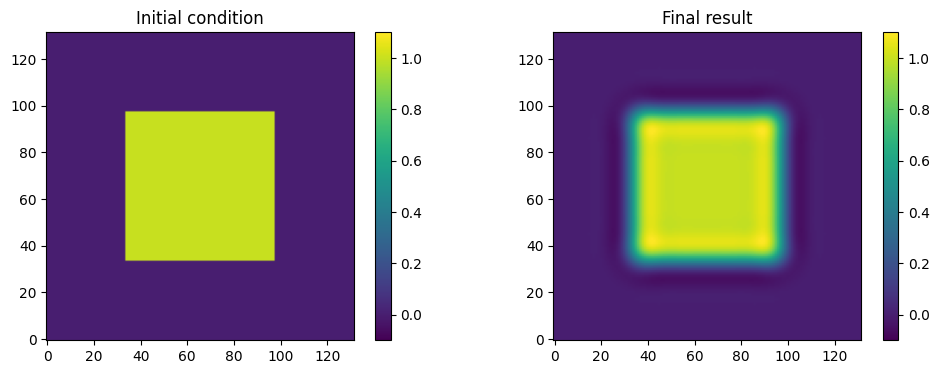

In [20]:
validate_results()

In [76]:
%%bash
nx_len=128
ny_len=128

out_file="out_${nx_len}_${ny_len}.txt"
dims_file="dims_${nx_len}_${ny_len}.txt"

if [ ! -f "$out_file" ]; then
  echo "runtimes = [[0.0]*17 for _ in range(73)]" > "$out_file"
fi

if [ ! -f "$dims_file" ]; then
  echo "dimensions = [[0.0]*17 for _ in range(73)]" > "$dims_file"
fi

for nthreads in $(seq 20 36); do
  export OMP_NUM_THREADS=$nthreads
  ncores=$nthreads

    for nnodes in 2; do
    if (( nthreads * nnodes > 72 )); then
      nnodes=$(( 72 / nthreads ))
    fi
      echo "Running with $nthreads threads and $nnodes MPI tasks"
      output=$(srun -n $nnodes ./stencil2d-kparallel_mpi.x --nx $nx_len --ny $ny_len --nz 64 --num_iter 1024)
    
      data_line=$(echo "$output" | grep -oP '\[\s*\d+,\s*\d+,\s*\d+,\s*\d+,\s*\d+,\s*[\d.E+-]+\]')
      runtime=$(echo "$data_line" | sed 's/.*\[//' | sed 's/\]//' | cut -d',' -f6 | xargs)
    
      dims_line=$(echo "$output" | grep -oP '\[\s*\d+,\s*\d+\]' | head -n1)
      nx=$(echo "$dims_line" | sed 's/[][]//g' | cut -d',' -f1 | xargs)
      ny=$(echo "$dims_line" | sed 's/[][]//g' | cut -d',' -f2 | xargs)
    
      # Update or append runtime
      if grep -q "runtimes\[$nthreads\]\[$nnodes\]" "$out_file"; then
        sed -i "s/runtimes\[$nthreads\]\[$nnodes\] = .*/runtimes[$nthreads][$nnodes] = $runtime/" "$out_file"
      else
        echo "runtimes[$nthreads][$nnodes] = $runtime" >> "$out_file"
      fi
    
      # Update or append dimensions
      if grep -q "dimensions\[$nthreads\]\[$nnodes\]" "$dims_file"; then
        sed -i "s/dimensions\[$nthreads\]\[$nnodes\] = .*/dimensions[$nthreads][$nnodes] = [$nx, $ny]/" "$dims_file"
      else
        echo "dimensions[$nthreads][$nnodes] = [$nx, $ny]" >> "$dims_file"
      fi
    done
done
done

Running with 20 threads and 2 MPI tasks


srun: Job 284356 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for StepId=284356.172


Running with 21 threads and 2 MPI tasks
Running with 22 threads and 2 MPI tasks
Running with 23 threads and 2 MPI tasks
Running with 24 threads and 2 MPI tasks
Running with 25 threads and 2 MPI tasks
Running with 26 threads and 2 MPI tasks
Running with 27 threads and 2 MPI tasks
Running with 28 threads and 2 MPI tasks
Running with 29 threads and 2 MPI tasks
Running with 30 threads and 2 MPI tasks
Running with 31 threads and 2 MPI tasks
Running with 32 threads and 2 MPI tasks
Running with 33 threads and 2 MPI tasks
Running with 34 threads and 2 MPI tasks
Running with 35 threads and 2 MPI tasks
Running with 36 threads and 2 MPI tasks


In [72]:
72/16

4.5

In [26]:
#### Define baseline runtime
exec(open("out_128_128.txt", "r").read())
T_baseline=runtimes[1][1]
print(T_baseline)

0.7204005


In [77]:
exec(open("out_128_128.txt", "r").read())

labels = []
times = []
speedups= []
for nthreads in range(len(runtimes)):
    for nnodes in range(len(runtimes[nthreads])):
        runtime = runtimes[nthreads][nnodes]
        if runtime > 0.0:  # only plot entries that were filled
            labels.append([nthreads, nnodes])
            times.append(runtime)
            speedups.append(T_baseline/runtime)

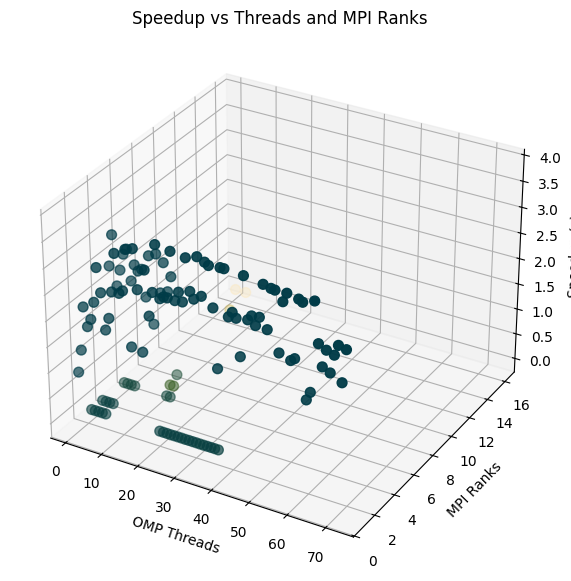

In [78]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

nthreads = [l[0] for l in labels]
ntasks = [l[1] for l in labels]

ax.scatter(nthreads, ntasks, speedups, c=times, cmap=cm.bamako, s=50)

ax.set_xlabel("OMP Threads")
ax.set_ylabel("MPI Ranks")
ax.set_zlabel("Speedup (s)")
ax.set_title("Speedup vs Threads and MPI Ranks")
plt.show()

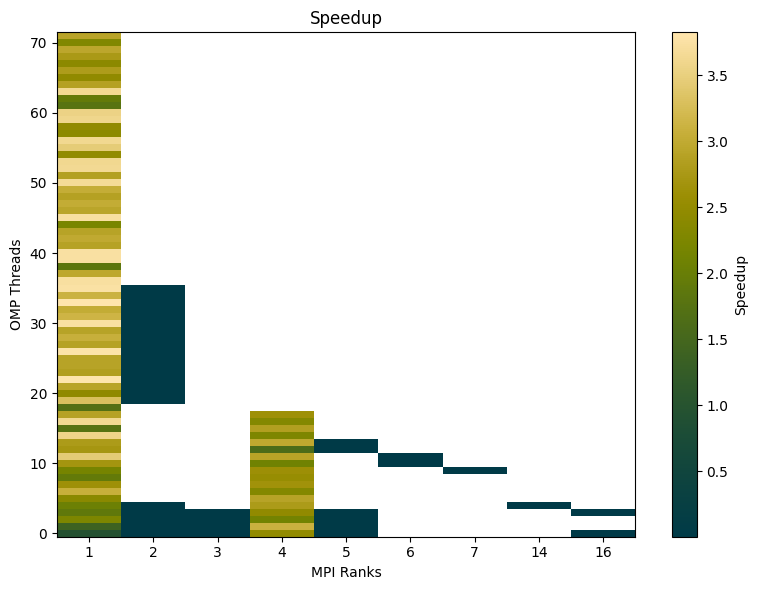

In [79]:

# Convert labels and times into a 2D grid
labels_array = np.array(labels)
nthreads = sorted(set(labels_array[:, 0]))
nranks = sorted(set(labels_array[:, 1]))

heatmap = np.full((len(nthreads), len(nranks)), np.nan)

for (t, r), val in zip(labels, speedups):
    i = nthreads.index(t)
    # i=nthreads[t]
    j = nranks.index(r)
    heatmap[i, j] = val

fig, ax = plt.subplots(figsize=(8, 6))
c = ax.imshow(heatmap, cmap=cm.bamako, origin='lower', 
              # extent=[min(nranks)-0.5, max(nranks)+0.5, min(nthreads)-0.5, max(nthreads)+0.5],
              aspect='auto')

ax.set_xlabel('MPI Ranks')
ax.set_ylabel('OMP Threads')
ax.set_title('Speedup')
fig.colorbar(c, label='Speedup')
ax.set_xticks(np.arange(len(nranks)))
ax.set_xticklabels(nranks)
plt.tight_layout()
plt.show()

In [ ]:
72/4

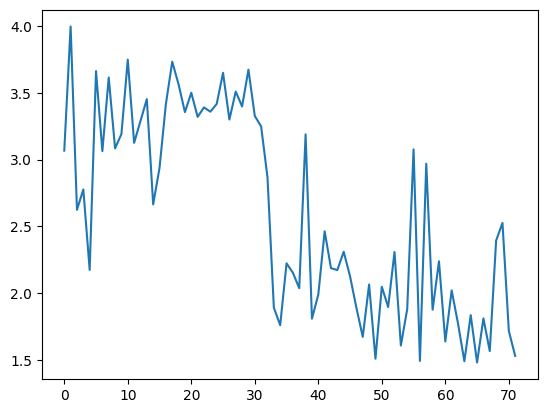

In [91]:
plt.plot(T_baseline/np.array(mpi_4[1:]))

In [82]:
T_baseline

0.0

In [77]:
mpi_4=[row[4] for row in runtimes]
mpi_4

[0.0,
 0.2912556,
 0.2234471,
 0.3404933,
 0.3217575,
 0.4110929,
 0.2438275,
 0.2915989,
 0.2470802,
 0.2896241,
 0.2799216,
 0.2382716,
 0.2857797,
 0.2715937,
 0.2586742,
 0.3352853,
 0.3040204,
 0.2614918,
 0.2392566,
 0.2506909,
 0.2661894,
 0.2551379,
 0.2690398,
 0.2634169,
 0.2659387,
 0.2614396,
 0.2447168,
 0.2706721,
 0.2545088,
 0.2628604,
 0.2431334,
 0.2684995,
 0.2749925,
 0.3115747,
 0.4725874,
 0.5079454,
 0.401917,
 0.4151072,
 0.438801,
 0.2801053,
 0.4941782,
 0.449298,
 0.3627803,
 0.408597,
 0.4112288,
 0.3868155,
 0.4203492,
 0.4728279,
 0.5345045,
 0.4328035,
 0.5925704,
 0.436396,
 0.4714909,
 0.3871382,
 0.5561341,
 0.475323,
 0.2903186,
 0.5990637,
 0.3008445,
 0.476465,
 0.399139,
 0.5457589,
 0.442351,
 0.5043288,
 0.6001055,
 0.48707,
 0.6038345,
 0.4936244,
 0.5709142,
 0.3733318,
 0.3537239,
 0.5206093,
 0.5843211]

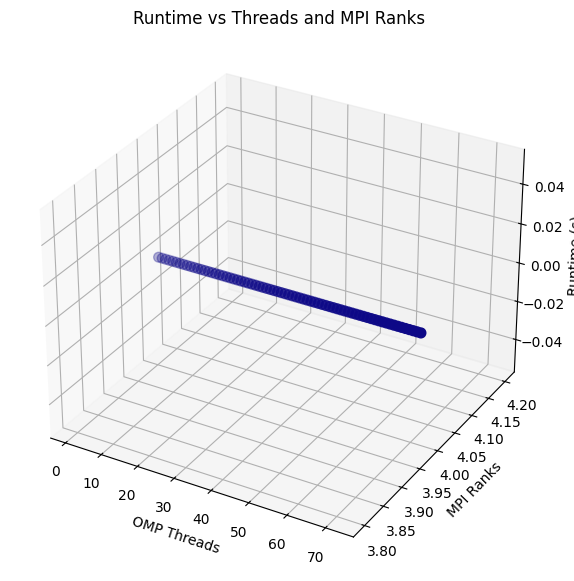

In [56]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

nthreads = [l[0] for l in labels]
ntasks = [l[1] for l in labels]

ax.scatter(nthreads, ntasks, times, c=times, cmap='plasma', s=50)

ax.set_xlabel("OMP Threads")
ax.set_ylabel("MPI Ranks")
ax.set_zlabel("Runtime (s)")
ax.set_title("Runtime vs Threads and MPI Ranks")
plt.show()